<a href="https://colab.research.google.com/github/JoelLEMI/Test/blob/main/Ase1_Intensity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code accesses a GitHub folder containing raw data: spindle positions (x, y) and Ase1 intensity along two spindles. It analyzes the curvature of each spindle and plots the results.

The spindles are aligned parallel to the X-axis, and the Ase1 intensity is interpolated along that axis. The code generates a figure and records the following values:


*   X1 and X2: the X-axis positions where Ase1 is localized
*   Ase1 length
*   Spindle length (as the X-axis projection)

These values are needed for the associated MATLAB code.

You can run this notebook in Google Colab by clicking the "Open in Colab" link above.

In [ ]:
import pandas as pd
import numpy as np
import math
from scipy.interpolate import interp1d
import csv
from scipy import signal
from matplotlib import pylab as plt
from scipy.optimize import curve_fit
from scipy import stats
from PIL import Image
from pylab import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import accumulate


def rad_from_points(x1, y1, x2, y2, x3, y3):

    '''
    takes coordinates of three points, (x1, y1), (x2, y2), and (x3, y3)
    and returns the radius (r), and the coordinates of the center (xc, yc)
    of the circle that passes through the three points.

    The center of the circle can be found by finding the intersection
    of the line that bisects the segment formed by (x1, y1) and (x2, y2),
    and the line that bisects the segment formed by (x2, y2) and (x3, y3).
    '''

    ma = (y2 - y1)/(x2 - x1)
    mb = (y3 - y2)/(x3 - x2)

    xc = (ma*mb*(y1 - y3) + mb*(x1 + x2) - ma*(x2 + x3))/(2*(mb - ma))
    yc = -1/ma*(xc - (x1 + x2)/2) + (y1 + y2)/2

    if ma == mb:
        r = np.inf
    else:
        r = np.hypot(xc - x1, yc - y1)

    return(r, xc, yc)


def radius_of_curvature_open(x_path, y_path, scale):

    '''
    takes a path and returns the signed curvature value at each
    point (along w/ the centers
    that form the evolute of the curve)
    '''

    r = []
    xcs = []
    ycs = []

    num_points = len(x_path)

    for i in range(scale,num_points-scale):
        # points
        x1 = x_path[i-int(scale)]
        y1 = y_path[i-int(scale)]
        x2 = x_path[i]
        y2 = y_path[i]
        x3 = x_path[i+int(scale)]
        y3 = y_path[i+int(scale)]

        # fit circle
        rad, xc, yc = rad_from_points(x1, y1, x2, y2, x3, y3)

        # get vector normal to path for sign of curvature
        nv1 = np.cross(np.array([x2 - x1, y2 - y1, 0]), np.array([0 ,0, 1]))
        nv2 = np.cross(np.array([x3 - x2, y3 - y2, 0]), np.array([0 ,0, 1]))

        nv = np.average([nv1, nv2], axis = 0)

        # get sign of dot product (and flip for convention that positive curvature is inward)
        align = -np.sign(np.dot(nv[0:2], np.array([x2 - xc, y2 - yc])))


        theta = np.linspace(-math.pi, math.pi, 100)
        x_plot = rad * np.cos(theta) + xc
        y_plot = rad * np.sin(theta) + yc

        if rad == 0:
            r.append(np.nan)
        else:
            r.append(align * 1./rad)

        xcs.append(xc)
        ycs.append(yc)

    return(r, xcs, ycs)

def rotation(x_arr,y_arr,angle):
    """Rotates a point around the origin (0,0) in the clockwise direction.
       Angle is in radians. Point is a tuple"""
    x_rot_arr, y_rot_arr = (x_arr*np.cos(angle)+y_arr*np.sin(angle),-x_arr*np.sin(angle)+y_arr*np.cos(angle))
    return x_rot_arr, y_rot_arr

def translation(x_arr,y_arr):
    """translate all points so that the first smallest value is the origin (0,0)"""
    if x_arr[99] <= x_arr[0]:
        x_trans_arr, y_trans_arr = (x_arr-x_arr[99],y_arr-y_arr[99])
    else:
        x_trans_arr, y_trans_arr = (x_arr-x_arr[0],y_arr-y_arr[0])
    return x_trans_arr, y_trans_arr

def flip(x_arr,y_arr):
    """flip the values in Y to get the curvarture upward all the time"""
    if min(y_arr) <= 0:
        y_flip_arr = (y_arr*-1)
    else:
        y_flip_arr =y_arr
    return x_arr, y_flip_arr

def reverse(x_arr,y_arr):
    """reverse values in X and get the values in rising order -important for curvature calculation- """
    if x_arr[99] <= x_arr[0]:
        x_rev=x_arr[::-1].reset_index(drop=True) ## twinking to reset the index after reversing
        y_rev=y_arr#[::-1]
    else:
        x_rev=x_arr
        y_rev=y_arr
    return x_rev, y_rev

In [ ]:
'''
    Option 1: Getting Data from GitHub
    '''
import os
# Base GitHub URL
folder_path = "https://raw.githubusercontent.com/JoelLEMI/Test/refs/heads/main/Data/Spindle%20Example%20Data/"

# Subfolder 'sp'
loc = os.path.join(folder_path, 'sp')

# Excluded Spindles (if data are not good enough for analysis)
Excluded = []

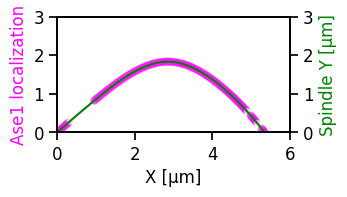

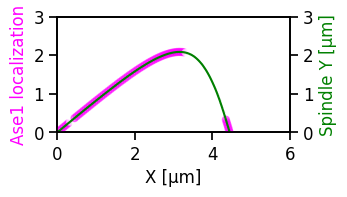

In [ ]:
scale=0 # I am not measuring curvature here
Ase1Boundary = [] # To save data on Ase1 location
L_Sp = [] #Spindle x-axis projected length
Sp_name = [] # To keep the name of the Sp

for i in range(3,5):
    if i in Excluded: #Add exclude not well imaged spindles from the analysis
            continue
    data=pd.read_csv('%s%s/sp%s.csv'%(loc,i,i))
    y_path_1=data["Y"]
    x_path_1=data["X"]

    ##rotate the data using the angle between the first and last point
    x_path_2,y_path_2 = reverse(x_path_1,y_path_1)
    angle = np.arctan((y_path_2[0] - y_path_2[99]) / (x_path_2[0] - x_path_2[99]))
    x_path_3,y_path_3 = rotation(x_path_2,y_path_2,angle)
    x_path_4,y_path_4 = translation(x_path_3,y_path_3)
    x_path,y_path = flip(x_path_4,y_path_4)

    # Input list initialization
    Inputx = x_path
    Inputy = y_path

    # list of length in which we have to split
    length_to_split = [scale, 100-2*scale, scale]

    # Using islice
    Outputx = [Inputx[x - y: x] for x, y in zip(accumulate(length_to_split), length_to_split)][1]
    Outputy = [Inputy[x - y: x] for x, y in zip(accumulate(length_to_split), length_to_split)][1]

    ##Ase1 Background Value per movie
    dataBG=pd.read_csv('%s%s/ase1_BG_sp%s.csv'%(loc,i,i), usecols= ["Mean"], nrows=1) #Reads Ase1 background intensity
    dataBG=dataBG["Mean"]

    ###Ase1
    data=pd.read_csv(f"{loc}{i}/Plot%20Values%20sp{i}.csv", encoding='latin1') # Open Ase1 intensity data
    y_int_1=data["Value"]-dataBG[0] #remove the background intensity from Ase1 value
    x_coord_1=data.iloc[:, 0]

    f = interp1d(x_coord_1, y_int_1, kind='cubic') #Interpolate the intensity to align with spindle length
    xnew = np.linspace(0, x_coord_1[len(x_coord_1)-1], num=100, endpoint=True) #create 100 points along the spindle

    # Replace values below A with 0 and values above A with 1, A is the intensity treshold
    A=0.15*max(f(xnew)[20:81]) # Looking at the middle of the spindle intensity
    transformed_array = np.where(f(xnew) < A, 0, 1)

    # Create the first plot
    a4_dims = (3,1.5)
    fig, ax1 = plt.subplots(figsize=a4_dims)
    sns.set_context("notebook", font_scale=1.5)

    # Create the second y-axis
    ax2 = ax1.twinx()
    ax2.plot(Outputx, Outputy, color='green',marker='.',alpha=1, markersize=0.1)
    ax2.scatter(Outputx,Outputy,marker='o',c=transformed_array,cmap=matplotlib.colors.ListedColormap(['white', 'magenta']), vmin=0, vmax=1,s=25,alpha=0.5)


    ax1.set_xlabel('X [µm]',fontsize=12)
    ax1.set_ylabel('Ase1 localization',fontsize=12, color='magenta')
    ax2.set_ylabel('Spindle Y [µm]',fontsize=12, color='green')

    # Set the size of ticks on the second y-axis
    tick_size_y = 12
    ax1.tick_params(axis='both', labelsize=tick_size_y)
    ax2.tick_params(axis='y', labelsize=tick_size_y)

    ax1.set_ylim([0,3])
    ax2.set_ylim([0,3])
    ax1.set_xlim([0,6])